Suhas Muniyappa, Clemens Westrup

# Introduction

This report is the result of a term project for the course “Algorithmic Methods of Data Mining” at Aalto University. The goal of this project was analyze randomized algorithms for streams. In particular the task was compute the so-called frequency moments of a stream, first using algorithms for exact computation and then comparing these to randomized algorithms for approximate computation with gains in

The code to run experiments for this project was implemented in `C`, `Julia` and `Python`. This report uses Julia [1] in combination with the Jupyter notebook [2]. With these prerequisites in place the project report can also be cloned form the following GitHub repository and run interactively: https://github.com/cle-ment/frequency-moments.

In [3]:
using Gadfly, DataFrames, SHA, Murmur3

## Computing the baseline

TODO: show exact results

# Exact Computation of Frequency Moments

## Single Pass

### In-place using sort

As a baseline for the other algorithms simple unix commands were used to compute the F0 and F2 moments. Computing F0 $-$ the distinct elements in the stream $-$ can be done using the following unix command: 

    sort <file> | uniq -c | wc -l 

The F2 moment $-$ the self-join of the stream $-$ can be computed with the following command: 
   
    sort <file> | uniq -c | tr -s ' ' | cut -d ' ' -f 2  | awk '{x+=$0*$0}END{print x}'

#### Implementation:

In Julia we have access to the shell so these commands can be implemented as Julia functions. This let's us compare runtime and memory usage.

In [ ]:
function unixF0(file)
    # calls the command via unix shell
    return parse(Int, readall(pipeline(`sort $file`, `uniq -c`, `wc -l`)))
end;

In [1]:
function unixF2(file)
    # calls the command via unix shell
    return parse(Int, readall(
        pipeline(`sort $file`, `uniq -c`, `tr -s ' '`, 
        `cut -d ' ' -f 2`, `awk '{x+=$0*$0}END{print x}'`)))
end;

#### Test:

In [ ]:
unixF0(toy_data[1000])

In [ ]:
unixF2(toy_data[1000])

#### Evaluation:

We'll calculate the moments on the toy data using the unix commands so we can compare the results to the other algorithms. First we calculate the correct results for both moments:

@ TODO: Mention F2 doesn't work in large data

### Using a dictionary

For both algorithms we will use a function that reads the stream/file once, stores the counts of each item in a Dictionary and returns an array with the counts of the items. Hence the space and time complexity are in $\mathcal{O}(n)$ since we need to keep an entry for each element in the stream in our Dictionary (space $\mathcal{O}(m)$) and we pass through each element once (time $\mathcal{O}(n)$).

In [17]:
function count_words(stream::IOStream, inputSize=0)
    wordcounts = Dict{UTF8String,Int}();
    # preallocate memory
    if inputSize > 0 
        sizehint!(wordcounts, inputSize)
    end
    while !eof(stream)
        word = readline(stream)
        wordcounts[word] = get(wordcounts, word, 0) + 1
    end
    return collect(values(wordcounts))
end;

(See section [Performance Considerations](#performance) so see why the while loop was chosen for iteration over the stream)

#### Algorithms

##### onePassF0

Compuing $F_0$ from our count array is then simply the length of the array since it contains an entry for every item seen in the stream.

In [18]:
onePassF0(file) = length(open(count_words, file));

##### onePassF2

To compute $F_2$ we will first need a function which squares an element. In Julia we can then simply vectorize this function using a macro so it takes an Array and can compute the values in abritary order, similarly to vector / matrix multiplication in Numpy, Matlab etc. This speeds up computation especially on multi-core machines.

In [19]:
square(x) = x^2
@vectorize_1arg Number square;

Now we can pass the count array from above into the vectorized square function and sum the result to compute $F_2$.

In [20]:
onePassF2(file) = sum(square(open(count_words, file)));

#### Analysis

In [ ]:
onePassF2("data/twitter_words-10000000.txt")

##### onePassF0

TODO: Explain and show correctness (with unix command?)

In [16]:
label_onePassF0 = "One Pass F0"
k = 100 # iterations;

results_onePassF0 = DataFrame(Label = AbstractString[], InputSize = Int[], Iterations= Int[],
    Result = Float16[], Error = Float16[], Time = Float16[], Space = Float16[])

for i in 1:length(toy_data_files)
    results_onePassF0 = vcat(results_onePassF0,
    @eval @measureCall(onePassF0(toy_data_files[$i]), 0, 10^$i, $k, $label_onePassF0))
end

results_onePassF0

LoadError: LoadError: UndefVarError: @measureCall not defined
while loading In[16], in expression starting on line 7

##### onePassF2

TODO: Explain and show correctness (with unix command?)

In [ ]:
label_onePassF2 = "One Pass F2"

k = 100 # iterations;

results_onePassF2 = DataFrame(Label = AbstractString[], InputSize = Int[], Iterations= Int[],
    Result = Float16[], Error = Float16[], Time = Float16[], Space = Float16[])

for i in 1:length(toy_data_files)
    results_onePassF2 = vcat(results_onePassF2,
    @eval @measureCall(onePassF2(toy_data_files[$i]),0, 10^$i, $k, $label_onePassF2))
end

results_onePassF2

## Multiple Passes

The spectrum between one passes and multiple passes presents a tradeoff between time and space complexity: If we find exact algorithms that require less memory we can achieve this by allowing multiple runs over the data which in turn results in longer computation time. 

While the algorithms above require minimal time ($\mathcal{O}(n)$) they require maximal space ($\mathcal{O}(n)$). The algorithms below show that we can inverse this relationship $-$ we can compute $F_2$ with n^2 passes in $\mathcal{O}(n^2)$ time with space complexity $\mathcal{O}(1)$ $-$ or find a hybrid solution which uses $\mathcal{\theta}(log n)$ in terms of expected space and $\mathcal{O}(n^2)$ in time.

### Algorithms

#### multiPassF2 

With multiple passes can keep the space complexity for computing $F_2$ in $\mathcal{O}(1)$ while the time complexity increases to $\mathcal{O}(n^2)$, using the following algorithm:

1. Initialize $F_2$ as 0
1. Read the stream element by element 
2. For each element iterate over the whole stream again and count the occurences of this element
3. Add this count to $F_2$ and proceed with the next element in the stream

The following implementation realizes a recursive version of this algorithm:

In [ ]:
function multiPassF2(file, input_word=false)
    f2 = 0
    open(file) do stream
        while !eof(stream) 
            word = readline(stream)
            if input_word === false
                f2 += multiPassF2(file, word)
            elseif word == input_word
                f2 += 1
            end
        end
    end
    return f2
end;

#### hybridF0F2

TODO: Explain algorithm and complexity

In [ ]:
function hybridF0F2(file)
    f0 = 0 # number of distinct elements
    f2 = 0 # index of homogenity
    
    # A dictionary stores previously seen elements and how often 
    # they will still appear in the stream to come
    element_counts = Dict{UTF8String,Int}()
    
    open(file) do filehandle
        for line in eachline(filehandle) 
            
            element_count = get(element_counts, line, 0)
            # check if the element was already seen 
            if element_count == 0 
                # element has not been seen yet
                f0 += 1
                # check how often it appears by scanning the whole stream
                frequency = multiPassF2(file, line)
                f2 += frequency^2
                if frequency > 1
                    # element appears more than once, so it will still be 
                    # seen 'frequency - 1' times
                    element_counts[line] = frequency - 1
                end
            elseif element_count > 0
                # decrease the element_count because it has been seen again
                element_counts[line] = element_count - 1
            end
            
        end
    end
    
    return f0, f2
end;

### Analysis

#### multiPassF2 

TODO: Explain

In [ ]:
@time multiPassF2(toy_data[1000])

#### hybridF0F2

TODO: Explain

In [ ]:
@time hybridF0F2(toy_data[1000])

# Approximate Computation of Frequency Moments

## Algorithms

### F0 - Flajolet-Martin Algorithm

TODO: Explain (especially correction factor and median/mean => variance/bias tradeoff that can be controlled via group_size_ratio)

In [ ]:
function fmaF0(file, num_hashes::Int, group_size_ratio::Float64)

    print(string("Using ", num_hashes, " hashes in ", num_groups,
        " median groups of size ", group_size))
    if num_hashes-group_size*(num_groups-1) < group_size
        print(string(" (last group has size ", num_hashes-group_size*(num_groups-1),
        " only due to rounding)"))
    end

    if group_size_ratio <= 0 || group_size_ratio > 1
        error("Choose parameter group_size_ratio in interval (0..1]")
        return
    end

    Φ = 0.77351 # correction factor, E(R) = log2Φn

    seeds = rand(1:num_hashes, num_hashes)
    max_tail_lengths = zeros(num_hashes)

    open(file) do filehandle
        for line in eachline(filehandle)
            
            for k in 1:length(seeds)
                tail_length = trailing_zeros(Murmur3.x86.hash32(line, seeds[k]))
                max_tail_lengths[k] = max(max_tail_lengths[k], tail_length)
            end
        end
    end

    max_tail_lengths = Φ * 2.^max_tail_lengths

    # take medians of groups and then the mean over them
    group_size = round(Int, num_hashes * group_size_ratio, RoundDown)
    num_groups = round(Int, num_hashes / group_size, RoundUp)

    medians = zeros(num_groups)
    for i in 1:num_groups
        group_start = (i-1)*group_size + 1
        group_end = i*group_size

        # the last group is smaller:
        if i == num_groups
            group_end = num_hashes
        end

        medians[i] = median(max_tail_lengths[group_start:group_end])
    end
    return mean(medians)
end;

## Alon-Matias-Szegedy Algorithm for F2

TODO: Explain implementation briefly

In [413]:
function amsF2(file, stream_size::Int, num_variables::Int)
#     ,group_size_ratio::Float64)

    # choose positions of variables in stream uniformly at random
    positions = sample(1:stream_size, num_variables, replace=false)

    # Dict that stores our variables and their values
    dict = Dict()

    open(file) do filehandle
        for (index, value) in enumerate(eachline(filehandle))

            # if the current stream element isn't in our Dict
            if get(dict, value, 0) == 0
                # check if we reached a position in the stream to
                # initialize our next variable
                if in(index, positions)
                    # store the element in our Dict
                    dict[value] = 1
                end
            else
                # the element is in our Dict, increase its count
                dict[value] += 1
            end
        end
    end
        
    estimates = (2 .* collect(values(dict)) .- 1) * stream_size
    
    return mean(estimates)
    
    
#     print(length(values(dict)))
#     print(values(dict))


    
#     # calculate estimates
#     estimates = stream_size * (collect(values(dict)) *2 - 1)
    
#     return sum(estimates)/length(dict)
            
#     return mean(estimates)

end

amsF2 (generic function with 3 methods)

In [414]:
amsF2(toy_data[1000], 1000, 1000) 

1320.185614849188

In [396]:
onePassF2(toy_data[1000])

2470

In [223]:
abs(amsF2(toy_data[10000], 10000, 10000) - onePassF2(toy_data[10000]))

177836.0

## Analysis

Maybe this section could go into the Appendix?

### Hash Functions

First we need a family of hash functions. Let's define a polynomial hash function which takes a string, a seed (to generate different hash values) and the desired length of the hash.

#### Polynomial hashes

Clemens shitty exp hash:

In [432]:
function polyhash(string::AbstractString, seed::Int, bits::Int)   
    maxval = 2^bits
    hash = maxval
    for char in collect(string)
        hash += Int(char) ^ seed + 42
    end
    return mod(hash, maxval)
end;

Proper polynomial hash in 32 and 1024 bit:

In [ ]:
#X^32 = X^0 + X^2 + X^3 + X^7
polynomial = zeros(32)

polynomial[1] = 1
polynomial[3] = 1
polynomial[4] = 1
polynomial[8] = 1

function polyhash32(str, seed)
    
    sum = 0
    hashInd = 0
    for (index, item) in enumerate(collect(str))
        sum += Int(item) $ seed
        hashInd += (Int(item) $ seed) * polynomial[mod(index, 32)+1]
    end
    return mod(mod(hashInd, sum) * length(str), (1<<32))
end    

In [520]:
#X^1024 = X^8 + X^7 + X^4 + X^0
poly_1024 = zeros(1024)

poly_1024[1] = 1
poly_1024[5] = 1
poly_1024[8] = 1
poly_1024[9] = 1

function polyhash1024(str, seed)
    sum = 0
    hashInd = 0
    for (index, item) in enumerate(collect(str))
        sum += Int(item) $ seed
        hashInd += (Int(item) $ seed) * poly_1024[index]
    end
    return mod(mod(hashInd, sum) * length(str), (1<<32))
end

polyhash1024 (generic function with 2 methods)

#### FNV-1a (32-bit)

<https://en.wikipedia.org/wiki/Fowler–Noll–Vo_hash_function>

In [522]:
function fna_hash(string::AbstractString, seed::Int)
    # 32bit settings:
    FNV_offset_basis = 2166136261 + seed
    FNV_prime = 16777619

    hash = FNV_offset_basis

    for char in collect(string)
        hash = hash $ Int(char) # xor
        hash = hash * FNV_prime
    end

    return hash
end

fna_hash (generic function with 1 method)

#### Analysis and comparision of hash functions

Plot the hash function with random strings to see how random its distribution is

In [ ]:
set_default_plot_size(10cm, 7cm)

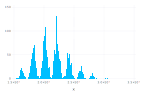

0.041319 seconds (670.98 k allocations: 19.760 MB, 8.12% gc time)


In [518]:
draws = 3000
hash_vals = zeros(Int, draws)
@time for i in 1:draws
    random_string = sha1(string(rand()))
    hash_vals[i] = polyhash32(random_string, 12)   
end
plot(x=hash_vals, Geom.histogram)

Looks okay (apart from the outlier)? See what happens with 19 bits:

In [ ]:
draws = 10000
hash_vals = zeros(Int, draws)
for i in 1:draws
    random_string = sha1(string(rand()))
    hash_vals[i] = polyhash1(random_string, 180, 19)   
end
plot(x=hash_vals, Geom.histogram)

... And at 20 bits we suddenly get what looks like a normal distribution with some patterns:

In [ ]:
draws = 10000
hash_vals = zeros(Int, draws)
for i in 1:draws
    random_string = sha1(string(rand()))
    hash_vals[i] = polyhash2(random_string, 180, 32)   
end
plot(x=hash_vals, Geom.histogram)

Let's do the same comparision with MurmurHash:

In [ ]:
draws = 1000
hash_vals = zeros(Int, draws)
for i in 1:draws
    random_string = sha1(string(rand()))
    hash_vals[i] = Murmur3.x86.hash32(random_string, 42)   
end
plot(x=hash_vals, Geom.histogram)

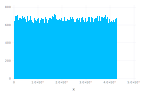

0.023620 seconds (598.98 k allocations: 10.666 MB)


In [514]:
draws = 100000
hash_vals = zeros(Int, draws)
random_string = "42 yeah"
@time for i in 1:draws
    rand_num = rand(1:1231231223)
    hash_vals[i] = Murmur3.x86.hash32(random_string, round(Int, rand_num))
end
plot(x=hash_vals, Geom.histogram)

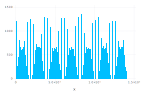

0.107623 seconds (3.76 M allocations: 66.496 MB, 8.35% gc time)


In [516]:
draws = 100000
hash_vals = zeros(Int, draws)
random_string = "42 yeah"
@time for i in 1:draws
    rand_num = rand(1:10000)
    hash_vals[i] = polyhash1024(random_string, round(Int, rand_num))
end
plot(x=hash_vals, Geom.histogram)

### F0 - Flajolet-Martin Algorithm

TODO: 

1. Show timed results with increasing input
2. Plot results with different hash functions, different numbers of hashes and different mean/meadian ratio

In [ ]:
fmaF0(toy_data[10000], 1000, 0.05)

### Alon-Matias-Szegedy Algorithm for F2

TODO: 

1. Show timed results with increasing input
2. Show with different numbers of variables

---------

# Appendix

# References

[1] http://julialang.org - "Julia is a high-level, high-performance dynamic programming language for technical computing"
[2] http://jupyter.org - "Open source, interactive data science and scientific computing across over 40 programming languages."
[3] N. Alon, Y. Matias, and M. Szegedy. The space complexity of approximating the frequency moments. In Proceedings of the twenty-eighth annual ACM symposium on theory of computing (STOC), pages 20–29, 1996.
[4] P. Flajolet and G. N. Martin. Probabilistic counting algorithms for data base applications. Jour- nal of computer and system sciences, 31(2):182–209, 1985.
[5] J. Leskovec, A. Rajaraman, and J. Ullman. Mining of massive datasets. Cambridge University Press, 2014.

The following Julia packages are needed:

In [512]:
using Gadfly, DataFrames, SHA, Murmur3;

## Tools for evaluation

A macro helps measure the time and space usage and computation error, averaged over k repetitions. Using the @timed macro we can create a macro that creates measurements of time, space and error during the same run (this function was slightly adapted for the different runs on triton):

In [ ]:
macro measureCall(function_call, expected_result,
    input_size, iterations, label)

    local local_expected_result = eval(expected_result)
    local local_input_size = eval(input_size)
    local local_iterations = eval(iterations)
    local local_label = eval(label)

    local result_mean = 0
    local squared_error_mean = 0
    local time_mean = 0.0
    local space_mean = 0.0

    for i = 1:iterations
        timed_result = @timed(eval(function_call))
        result_mean += timed_result[1]
        squared_error_mean += (local_expected_result - timed_result[1])^2
        time_mean += timed_result[2]
        space_mean += timed_result[3]
    end

    result_mean = result_mean / local_iterations
    squared_error_mean = sqrt(squared_error_mean / local_iterations)
    time_mean = time_mean / local_iterations
    space_mean = space_mean / local_iterations

    return DataFrame(
        Label = local_label,
        InputSize = local_input_size,
        Iterations= local_iterations,
        Result = result_mean,
        Error = squared_error_mean,
        Time = time_mean,
        Space = space_mean)
end

Create a function that denormalized / groupes the measurement dataframe that comes from the above macro. This helps for creating a grouped visualization with Gadfly.

In [ ]:
function denormalizeMeasurements(df::DataFrame)
    labels_error = fill("Error",size(df,1))
    labels_time = fill("Time",size(df,1))
    labels_space = fill("Space",size(df,1))
    
    return rename!(vcat(
        hcat(rename!(df[:, 
            [:Label, :InputSize, :Iterations, :Error]],
            :Error, :Measurement), labels_error),
        hcat(rename!(
            df[:, [:Label, :InputSize, :Iterations, :Time]], 
            :Time, :Measurement), labels_time),
        hcat(rename!(
            df[:, [:Label, :InputSize, :Iterations, :Space]], 
            :Space, :Measurement), labels_space)
        ), :x1, :Type)
end;

## Data

We use an extracts of the data as toy datasets so we can test the performance of the algorithms and verify they perform in a correct manner. The files are extracts of the first $n$ lines using the $head$ command, growing logarithmically in number.

In [10]:
toy_data_counts = [
    10
    ,100
    ,1000
    ,10000
    ,100000
]
toy_data_files = [
     "../data/twitter/noblanks-10.txt"
    ,"../data/twitter/noblanks-100.txt"
    ,"../data/twitter/noblanks-1000.txt"
    ,"../data/twitter/noblanks-10000.txt"
    ,"../data/twitter/noblanks-100000.txt"
]
toy_data = Dict{Int, AbstractString}(zip(toy_data_counts, toy_data_files));

The full data can be accessed as well for the actual calculations

In [ ]:
# full_data = "./data/twitter/noblanks.txt"
# full_data_blanks = "./data/twitter/twitter-words.txt"

##  <a name="performance"></a> Performance Considerations

Iteration with different methods makes a huge difference. Here are the averaged measurements of running the onePassF0 algorithm with different ways of accessing the stream ("gc time" stands for time spent on garbage collection):

1. an eachline iterator i.e. `for word in eachline(stream)`
2. the readlines function `for word in readlines(stream)
3. a while loop i.e. `while !eof(stream)` with a single `readline` in each iteration

method        | avg. measurement (1.000.000 items)
--------------|---------------------------------
1. eachline   | 0.123780 seconds (327.50 k allocations: 17.790 MB, 11.80% gc time)
2. readlines  | 0.102863 seconds (277.43 k allocations: 19.010 MB, 11.08% gc time)
3. while      | 0.109317 seconds (277.01 k allocations: 16.993 MB, 12.13% gc time)

method        | avg. measurement (10.000.000 items)
--------------|---------------------------------
1. eachline   | 18.740204 seconds (39.44 M allocations: 1.383 GB, 44.26% gc time)
2. readlines  | 11.644732 seconds (32.04 M allocations: 1.399 GB, 19.80% gc time)
3. while      | 8.116754 seconds (32.04 M allocations: 1.273 GB)


# References

1. N. Alon, Y. Matias, and M. Szegedy. The space complexity of approximating the frequency moments. In Proceedings of the twenty-eighth annual ACM symposium on theory of computing (STOC), pages 20–29, 1996.
2. P. Flajolet and G. N. Martin. Probabilistic counting algorithms for data base applications. Jour- nal of computer and system sciences, 31(2):182–209, 1985.
3. J. Leskovec, A. Rajaraman, and J. Ullman. Mining of massive datasets. Cambridge University Press, 2014.
4. Bar-Yossef, Ziv, et al. "Counting distinct elements in a data stream." Randomization and Approximation Techniques in Computer Science. Springer Berlin Heidelberg, 2002. 1-10.